# Visualization
This notebook crawls for the inference results of our architecture and visualizes the detected bees.

In [1]:
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
import json
from pathlib import Path
from tqdm import tqdm

In [ ]:
param_file = 'parameters.json'
params = json.load(open(param_file))

In [2]:
s3_connection = boto3.resource('s3')
s3_client = boto3.client('s3')

In [11]:
#Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#PDX-License-Identifier: MIT-0 (For details, see https://github.com/awsdocs/amazon-rekognition-custom-labels-developer-guide/blob/master/LICENSE-SAMPLECODE.)

def display_image(bucket,photo,response,min_confidence=10):
    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')

    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    # calculate and display bounding boxes for each detected custom label
    print('\n')
    print('Detected custom labels for ' + photo)
    for customLabel in response['CustomLabels']:
        if customLabel['Confidence'] < min_confidence:
            continue
        
        print('\nLabel ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            fnt = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif.ttf', 20)
            draw.text((left,top), customLabel['Name'], fill='#00d400', font=fnt)

            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Label Width: ' + "{0:.0f}".format(width))
            print('Label Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    display(image)

In [12]:
BUCKET = 'customlabels-bee-dataset'
PREFIX = 'test_images'

paginator = s3_client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET, Prefix=PREFIX)
inference_objects = []
for page in tqdm(pages):
    inference_objects = inference_objects + page['Contents']

inference_list = [f['Key'] for f in inference_objects
                  if Path(f['Key']).suffix == '.json']

print(f'Found {len(inference_list)} inference results.')

1it [00:00, 18.98it/s]

Found 1 inference results.




Detected custom labels for test_images/3898660.jpg

Label bee
Confidence 99.99800109863281
Left: 120
Top: 252
Label Width: 67
Label Height: 63

Label bee
Confidence 99.99700164794922
Left: 220
Top: 9
Label Width: 76
Label Height: 50

Label bee
Confidence 99.99700164794922
Left: 352
Top: 127
Label Width: 60
Label Height: 39

Label bee
Confidence 99.99500274658203
Left: 3
Top: 301
Label Width: 58
Label Height: 68

Label bee
Confidence 99.99500274658203
Left: 86
Top: 36
Label Width: 55
Label Height: 71

Label bee
Confidence 99.99300384521484
Left: 329
Top: 86
Label Width: 69
Label Height: 40

Label bee
Confidence 99.99300384521484
Left: 296
Top: 179
Label Width: 50
Label Height: 56

Label bee
Confidence 99.99300384521484
Left: 171
Top: 160
Label Width: 72
Label Height: 50

Label bee
Confidence 99.99200439453125
Left: 189
Top: 261
Label Width: 75
Label Height: 57

Label bee
Confidence 99.99099731445312
Left: 441
Top: 155
Label Width: 54
Label Height: 41

Label bee
Confidence 99.989006042

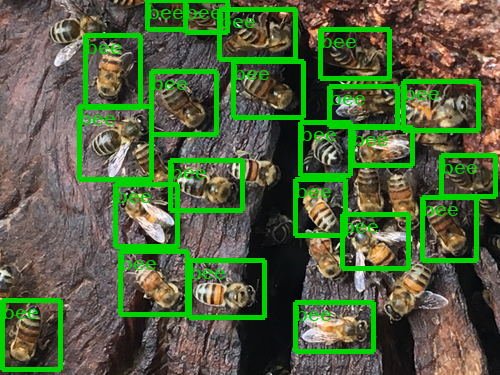

In [13]:
min_confidence = 10
for inference_key in inference_list[:500]:
    p = Path(inference_key)
    image_key = str(Path(*p.parents)/p.stem)
    
    s3_object = s3_connection.Object(BUCKET, inference_key)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    response = json.load(stream)
    
    n = len([c for c in response['CustomLabels'] if c['Confidence'] > min_confidence])
    # For object detection use case, uncomment below code to display image.
    if n:
        display_image(BUCKET,image_key,response,min_confidence)